# Imports

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Loading the data

In [3]:
df = pd.read_csv("../../data/stats/stats_processed.csv", sep=';')
df.head(5)

,winner_name,loser_name,event_date,method,round,time,time_format,bout_type,event_name,event_location,...,delta_height,delta_reach,delta_slpm_cs,delta_str_acc_cs,delta_sapm_cs,delta_str_def_cs,delta_td_avg_cs,delta_td_acc_cs,delta_td_def_cs,delta_sub_avg_cs
0,ILIA TOPURIA,MAX HOLLOWAY,26/10/2024,KO/TKO,3.0,1:34,5 Rnd (5-5-5-5-5),UFC Featherweight Title Bout,UFC 308: Topuria vs. Holloway,"Abu Dhabi, Abu Dhabi, United Arab Emirates",...,-10.16,0.00,-4.76,-1.0,-2.71,8.0,4.04,-16.0,16.0,3.9
1,KHAMZAT CHIMAEV,ROBERT WHITTAKER,26/10/2024,Submission,1.0,3:34,5 Rnd (5-5-5-5-5),Middleweight Bout,UFC 308: Topuria vs. Holloway,"Abu Dhabi, Abu Dhabi, United Arab Emirates",...,5.08,5.08,4.51,32.0,-3.34,6.0,4.24,48.0,-84.0,3.1
2,MAGOMED ANKALAEV,ALEKSANDAR RAKIC,26/10/2024,Decision - Unanimous,3.0,5:00,3 Rnd (5-5-5),Light Heavyweight Bout,UFC 308: Topuria vs. Holloway,"Abu Dhabi, Abu Dhabi, United Arab Emirates",...,-2.54,-7.62,-0.82,1.0,-0.45,13.0,0.43,8.0,-5.0,-0.2
3,LERONE MURPHY,DAN IGE,26/10/2024,Decision - Unanimous,3.0,5:00,3 Rnd (5-5-5),Featherweight Bout,UFC 308: Topuria vs. Holloway,"Abu Dhabi, Abu Dhabi, United Arab Emirates",...,5.08,5.08,-1.09,-4.0,-1.29,5.0,-0.81,6.0,-18.0,0.4
4,SHARA MAGOMEDOV,ARMEN PETROSYAN,26/10/2024,KO/TKO,2.0,4:52,3 Rnd (5-5-5),Middleweight Bout,UFC 308: Topuria vs. Holloway,"Abu Dhabi, Abu Dhabi, United Arab Emirates",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Explaining features

The features (columns) break down into 2 categories:
* **Categorical features**: Categorical features contain general fight/athlete data like: Fighters' names, nicknames, date of the event, location, number of rounds, time format, etc. Categorical features do not start with prefix `delta`, i.e. all numerical features start with prefix `delta`, the rest are categorical.
* **Numerical features**: These features contain all possible statistical details of the fight. Some of these are: The number of strikes landed, the number of significant strikes landed, the number of submissions attempted, the percentage ratio of the strikes that were landed to the head, the percentage ratio of the strikes that were landed in clinch position, etc. The numerical features, as already mentioned, can be identified by their prefix `delta`.

**Note:** Delta features can be interpreted as follows:<br>
`Delta` - is the difference between two values or metrics, often used to quantify change between different groups.<br>
So in our case `delta_feature_x` is the difference between **the winner's** `feature_x` and **the loser's** `feature_x`. <br><br>For example: <br>
There's `winner_total_strikes_landed` and `loser_total_strikes_landed`.<br>
> `delta_total_strikes_landed` = `winner_total_strikes_landed` - `loser_total_strikes_landed`. <br>

If the value of delta is *positive*, that means the **winner's** performance in that partical feature is **higher**, if the value is *negative*, it means the winner's contribution in that feature was lower compared to loser's, if it *equals 0*, it means the contribution from the winner and loser was **equal**.

* `winner_name`          - The name of the winner of the fight: ('ILIA TOPURIA', 'KHAMZAT CHIMAEV', etc.)
* `loser_name`           - The name of the loser of the fight: ('LERONE MURPHY', 'GEOFF NEAL', etc.)
* `event_date`           - The date of when event took place: ('26/10/2024', '19/10/2024', etc.)
* `winner_nickname`      - The nickname of the winner of the fight: ('El Matador', 'Borz', etc.)
* `loser_nickname`       - The nickname of the loser of the fight: ('Blessed', 'The Reaper', etc.)
* `method`               - The method of victory: ('KO/TKO', 'Submission', Decision - Unanimous', 'Decision - Split', etc.)
* `round`                - The round in which the victory was gained: ('3', '5', '1', etc.)
* `time`                 - The time of the round in which the victory was gained: ('1:34', '3:34', etc.)
* `time_format`          - Time format of the fight and how many rounds: ('5 Rnd (5-5-5-5-5)', '3 Rnd (5-5-5)', etc.)
* `referee`              - The name of the referee: ('Marc Goddard', 'Jason Herzog', etc.)
* `details`              - The details of the victory: ('Punch to Head At Distance', 'Rear Naked Choke', scorecards, etc.)
* `bout_type`            - Bout type: ('UFC Featherweight Title Bout', 'Middleweight Bout', 'Light Heavyweight Bout', etc.)
* `bonus`                - The bonus that the fight got: ('Performance of the night', 'knockout of the night', etc.)
* `event_name`           - The name of the event: ('UFC 308: Topuria vs. Holloway', 'UFC Fight Night: Hernandez vs. Pereira')
* `event_location`       - The location of the event: ('Las Vegas, Nevada, USA', 'Paris, Ile-de-France, France', etc)
* `winner_stance`        - Winner's fighting stance: ('Orthodox', 'Southpaw', etc.)
* `loser_stance`         - Loser's fighting stance: ('Switch', 'Southpaw', etc.)
* `winner`               - The fighter of which corner won: ('Red', 'Blue', etc.)
* `delta_KD`             - The delta difference in landed Knockdowns by strikes: (1,  0, -1)
* `delta_sig_str_pct`    - The delta difference in landed significant strikes in %: (14, -25,  3,)
* `delta_total_str_pct`  - The delta difference in landed total strikes in %: (significant and insignificant) : (14, -25,  3,)
* `delta_TD_pct`         - The delta difference in landed takedowns in %: (14, -25,  3,)
* `delta_sub_att`        - The delta difference in submission attempts: 
* `delta_rev`            - The delta difference in wrestling reversals (where a fighter reverses a disadvantageous position into advantageous). 
* `delta_ctrl`           - The delta difference in the fighter's control of the fight, in seconds
* `delta_sig_str_head_acc_pct` - The delta difference in accuracy (fraction of landed out of the total thrown) of landing significant strikes to the head in %
* `delta_sig_str_body_acc_pct` - The delta difference in accuracy (fraction of landed out of the total thrown) of landing significant strikes to the body in %
* `delta_sig_str_leg_acc_pct`  - The delta difference in accuracy (fraction of landed out of the total thrown) of landing significant strikes to the leg in %
* `delta_sig_str_distance_acc_pct` - The delta difference in accuracy (fraction of landed out of the total thrown) of landing significant strikes from the distance in % 
* `delta_sig_str_clinch_acc_pct` - The delta difference in accuracy (fraction of landed out of the total thrown) of landing significant strikes from the clinch in % 
* `delta_sig_str_ground_acc_pct` - The delta difference in accuracy (fraction of landed out of the total thrown) of landing significant strikes from the ground in % 
* `delta_sig_str_head_tar_pct` - The delta difference in contribution (fraction of strikes that were landed on the specified target out of the total 100% pool of 3 possible targets: head, body, legs) of significant strikes to the head in %
* `delta_sig_str_body_tar_pct` - The delta difference in contribution (fraction of strikes that were landed on the specified target out of the total 100% pool of 3 possible targets: head, body, legs) of significant strikes to the body in %
* `delta_sig_str_leg_tar_pct` - The delta difference in contribution (fraction of strikes that were landed on the specified target out of the total 100% pool of 3 possible targets: head, body, legs) of significant strikes to the leg in %
* `delta_sig_str_distance_pos_pct` - The delta difference in contribution (fraction of strikes that were landed from the specified position out of the total 100% pool of 3 possible positions: distance, clinch, ground) of significant strikes from the distance in %
* `delta_sig_str_clinch_pos_pct` - The delta difference in contribution (fraction of strikes that were landed from the specified position out of the total 100% pool of 3 possible positions: distance, clinch, ground) of significant strikes from clinch in %
* `delta_sig_str_ground_pos_pct` - The delta difference in contribution (fraction of strikes that were landed from the specified position out of the total 100% pool of 3 possible positions: distance, clinch, ground) of significant strikes from the ground in %
* `delta_height` - The delta difference in fighters' height
* `delta_reach` - The delta difference in fighters' arms reach
* `delta_slpm_cs` - The delta difference in fighters' total career statistic (computed from all fights) Significant Strikes Landed per Minute
* `delta_str_acc_cs` - The delta difference in fighters' total career statistic (computed from all fights) Significant Striking Accuracy
* `delta_sapm_cs` - The delta difference in fighters' total career statistic (computed from all fights) Significant Strikes Absorbed per Minute
* `delta_str_def_cs` - The delta difference in fighters' total career statistic (computed from all fights) Significant Strike Defence (the % of opponents' strikes that did not land)
* `delta_td_avg_cs` - The delta difference in fighters' total career statistic (computed from all fights) Average Takedowns Landed per 15 minutes
* `delta_td_acc_cs` - The delta difference in fighters' total career statistic (computed from all fights) Takedown Accuracy
* `delta_td_def_cs` - The delta difference in fighters' total career statistic (computed from all fights) Takedown Defense (the % of opponents' TD attempts that did not land)
* `delta_sub_avg_cs` - The delta difference in fighters' total career statistic (computed from all fights) Average Submissions Attempted per 15 minutes
* `delta_striking_dominance` - The delta difference in fighters' striking dominance (number of knockdowns + number of significant strikes landed + number of total strikes landed
* `delta_wrestling_dominance` - The delta difference in fighters' wrestling dominance (number of takedowns landed + number of submission attempts + number of reversals)

# Table of contents
- [Establishing Questions](#Establishing-questions)
- [Data Preprocessing](#Data-preprocessing)
- [Data Cleaning](#Data-Cleaning)
  - [NaN values](#NaN-values)
  - [Duplicates](#Duplicates)
- [Feature Enginering](#Feature-Engineering)
    - [Standardizing Features](#Standardizing-Features)
    - [Dropping Redundant Features](#Dropping-Redundant-Features)
    - [Converting Dtypes](#Converting-Dtypes)
    - [Engineering New Features](#Engineering-New-Features)
- [EDA](#EDA)
    - [1. What are the most popular locations where UFC hosts its events?](#1.-What-are-the-most-popular-locations-where-UFC-hosts-its-events?)
    - [2. What is the historical average amount of UFC fights hosted annually?](#2.-What-is-the-historical-average-amount-of-UFC-fights-hosted-annually?)
    - [3. What are the top fight outcomes?](#3.-What-are-the-top-fight-outcomes?)
    - [4. Does being in a particular corner contribute to a victory?](#4.-Does-being-in-a-particular-corner-contribute-to-a-victory?)
    - [5. What are the main fight tactics contributing to a victory?](#5.-What-are-the-main-fight-tactics-contributing-to-a-victory?)
- [Answering questions](#Answering-questions)
    - [Questions](#Questions)
    - [Answers](#Answers)

# Establishing questions

### Here are a few questions I want to be answered by the end of this notebook:
1. What are the most popular locations where UFC hosts its events?
2. What is the historical average amount of UFC events hosted annually?
3. What are the top fight outcomes?
4. Does being in a particular corner contribute to a victory?
5. Does having a specific fighting stance contribute to a victory?
6. What are the main fight tactics contributing to a victory?
7. Do any specific anthropometric features (like height, reach, etc.) contribute to a victory?
8. Based on the findings, can we use the information to bet on a fighter?

# EDA

## 1. What are the most popular locations where UFC hosts its events?

### Top countries by # of UFC events

Preparing the data:

In [4]:
# Dropping duplicates to keep only one event per date
events = df[['event_name', 'event_location']].drop_duplicates()

# Getting the location counts
counts = events['event_location'].value_counts()

# Make 'event_location' a column and rename the 'count' column to 'num_of_events'
top_locations = counts.reset_index().rename(columns={'count': 'num_of_events'})
top_locations['country'] = top_locations['event_location'].apply(lambda x: x.split(',')[-1].strip())
top_locations.head()

,event_location,num_of_events,country
0,"Las Vegas, Nevada, USA",245,USA
1,"Abu Dhabi, Abu Dhabi, United Arab Emirates",18,United Arab Emirates
2,"London, England, United Kingdom",15,United Kingdom
3,"Anaheim, California, USA",10,USA
4,"Atlantic City, New Jersey, USA",10,USA


In [5]:
top_countries = top_locations.copy()
# Sum by countries
top_countries = top_countries.groupby('country').sum().sort_values(by='num_of_events', ascending=False).reset_index()
# Drop column to keep it clean
top_countries.drop(columns=["event_location"], inplace=True)
top_countries.head()

,country,num_of_events
0,USA,502
1,Brazil,40
2,Canada,33
3,United Kingdom,29
4,United Arab Emirates,20


Add ISO3 country codes for plotting in choropleth:

In [6]:
import country_converter as coco
cc = coco.CountryConverter()

# Convert countries to ISO alpha-3 format
top_countries['iso_alpha'] = cc.pandas_convert(series=top_countries['country'], to='ISO3')

# Change column positions
top_countries = top_countries.iloc[:, [0, 2, 1]]
top_countries.head()

,country,iso_alpha,num_of_events
0,USA,USA,502
1,Brazil,BRA,40
2,Canada,CAN,33
3,United Kingdom,GBR,29
4,United Arab Emirates,ARE,20


Let's add log scaled version of the counts, as the range between the top1 and top 2 is huge and the choropleth gradient color is going to eat away all of the empty 40 - 500 range:

In [7]:
top_countries['log_num_of_events'] = np.log(top_countries['num_of_events'])
top_countries.head()

,country,iso_alpha,num_of_events,log_num_of_events
0,USA,USA,502,6.218600
1,Brazil,BRA,40,3.688879
2,Canada,CAN,33,3.496508
3,United Kingdom,GBR,29,3.367296
4,United Arab Emirates,ARE,20,2.995732


Plotting:

### Top countries by the number of UFC events on their soil (log-scaled)

We will add the log-scaled version of the `num_of_events` feature, as the deviation from the max value *(USA, **501**)* to the rest of the data *(Others, **1-40**)* is extremely large which would lead to choropleth stretching the color scale too much and that would make all of the other (non-USA) countries effectively the same color.

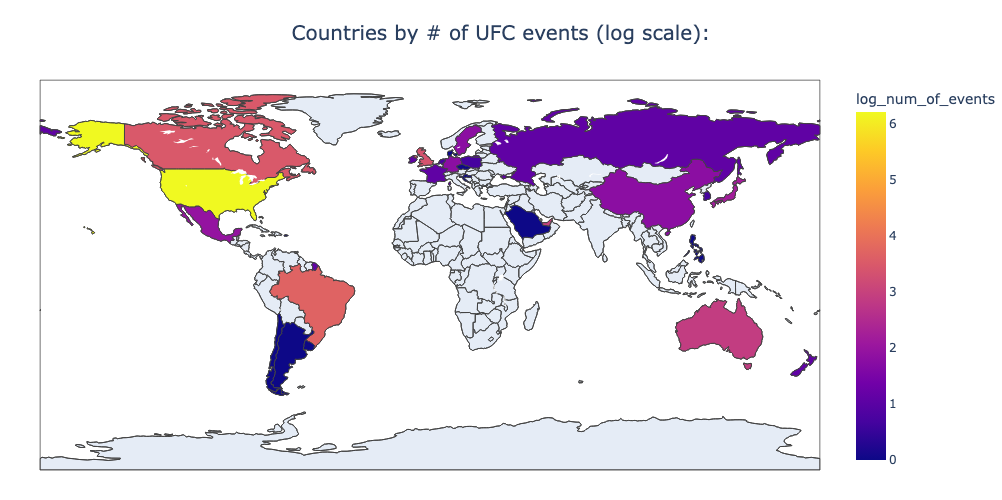

In [8]:
import plotly.express as px
import numpy as np


fig = px.choropleth(top_countries, # Plot data
                    locations='iso_alpha', # Use ISO codes as location identifiers
                    color='log_num_of_events', # Coloring based on log scaled num_of_events
                    hover_name='country', # On hover display country
                    title ="Countries by # of UFC events (log scale):",
                    color_continuous_scale=px.colors.sequential.Plasma)


# Make bigger and clearer
fig.update_layout(
    title={"x": 0.5, "font_size": 20},
    height=500, width=1000,
    geo=dict(showcountries=True),
    margin=dict(l=30, r=30, t=80, b=30)
)
fig.show()

#### Non-log version of the top 20 countries

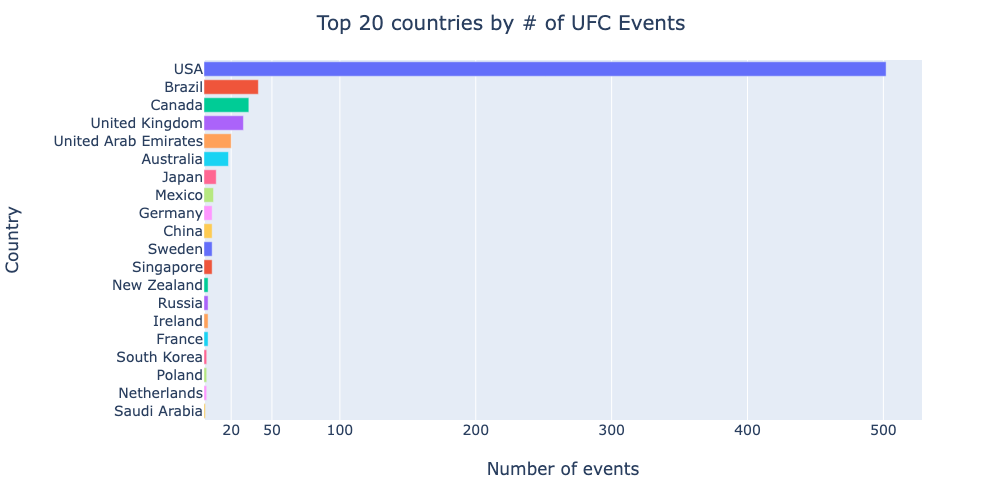

In [9]:
fig = px.bar(top_countries[:20], x="num_of_events", y="country", color="country")


fig.update_layout(title={"text": "Top 20 countries by # of UFC Events", "x": 0.5, "font_size": 20},
                  font={"size": 14}, 
                  xaxis=dict(
                      tickmode='array', tickvals=[20, 50, 100, 200, 300, 400, 500],
                      title = "Number of events", title_standoff=25
                  ),
                  yaxis=dict(
                      title="Country", title_standoff=40
                  ),
                  
                  showlegend=False, height=500)

fig.show()

The homeland to the UFC - The USA is the clear dominant here, followed by: Brazil, Canada, the UK, the UAE, Australia, Japan, and others.

The US is obviously the first because it is, again, the homeland, also I think because of the fact that regulation concerns were cleared up over the years and overall the UFC is given a thumbs up for the events as they don't have any additional regulatory requirements to comply with as they would have to do in hosting events internationally.

That said, by looking at other countries:<br>
* Brazil is ranked at #2. And what contributes to that is the cultural roots of Brazilian jiu-jitsu, as well as the BJJ grand-master co-founder, the second top country that is the hometown to the most UFC champions, and massive fan appetite like UFC 134 in Rio selling out tickets in 74 minutes and drawing ~35 million TV viewers, which accounts to about x10 the network's average.
* Canada sits at #3. Canada is the most profitable international market for UFC, in addition to that: massive MMA fan base, popularity of one of the best UFC fighters in history, who is a canadian, George St-Pierre, and strong Canadian regulatory support after legalization in major provinces make it the #2.
* UK at #4 is the premiere MMA hub in Europe (London, Manchester). Loyal fanbase, home to stars like Bisping, Aspinall; Prime timezone for capturing European/US crossover audiences and provides fertile ground for local talent development, e.g. Cage Warriors (the UK-based MMA promotion) to UFC pipeline, e.g. Conor McGregor.
* #5, UAE. UAE isn't known for huge MMA fanbases, local stars or notably strong PPV numbers, but it has its own reasons. Massive government funding and infrastructure support, e.g. they helped UFC build "Fight Island" on Yas Island during COVID. As well as, showcases MMA as a global sport to regional audiences.
* Australia at #6. Australian fans are known to be loud, loyal, and spend-heavy. Local champions like Alexander Volkanovski, Israel Adesanya, Robert Whittaker keep demand high.
* Japan, #7. Japan was once the global center of MMA - Pride FC, Shooto, Pancrase. So UFC tried to capture that market and attempted expansion in early 2000s, then again with UFC Japan events in late 2010s. It is known for deep martial arts culture and knowlegable fans.

But let's take a look at the ratio that it has with respect to the total pool of events in all of the countries:

In [10]:
# Calculate what pct of UFC events take place in the US
usa_pct = (top_countries["num_of_events"] / sum(top_countries["num_of_events"]) * 100).iloc[0]

# Prep the data
pct = pd.DataFrame({"country": ["USA", "Others"], "pct_of_events": [usa_pct, 100 - usa_pct]})
pct

,country,pct_of_events
0,USA,70.803949
1,Others,29.196051


Plot:

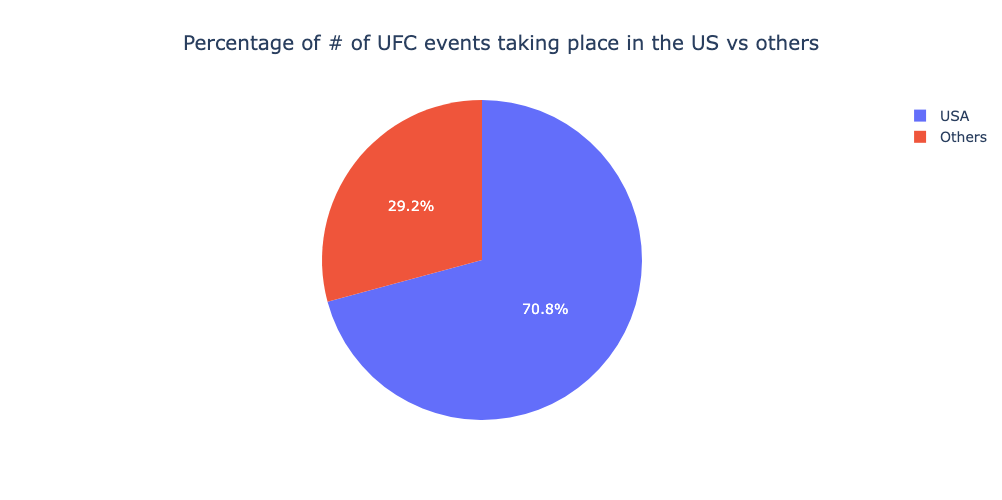

In [11]:
fig = px.pie(pct, values="pct_of_events", names="country",
             title="Percentage of # of UFC events taking place in the US vs others", height=500)

fig.update_layout(title={"x": 0.5, "font_size": 20},
                  font={"size": 14})

fig.update_traces(textfont_size=14, textfont={'color': 'white'})

fig.show()

70.8% is the USA only! Alright, but let's take a look at the states:

### Top US states by # of UFC events

#### Preparing the data

Let's prep the data:

In [12]:
# Get a separate df for the top US states
top_states = top_locations[top_locations['country'] == 'USA'].copy()
# Extract the states from 'event_location' column
top_states['state'] = top_states['event_location'].apply(lambda x: x.split(',')[-2].strip())
# Count the number of events per state and sort
top_states = top_states.groupby('state').sum('num_of_events').sort_values(by='num_of_events', ascending=False).reset_index()

# A dictionary that maps full state names to their abbreviations
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "DC": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands, U.S.": "VI",
}

# Mapping to abbreviations
top_states['state_abv'] = top_states['state'].apply(lambda x: us_state_to_abbrev[x])
top_states.head()

,state,num_of_events,state_abv
0,Nevada,245,NV
1,California,33,CA
2,Texas,25,TX
3,Florida,22,FL
4,New Jersey,22,NJ


### Plotting

In [13]:
top_states['log_num_of_events'] = np.log(top_states["num_of_events"])

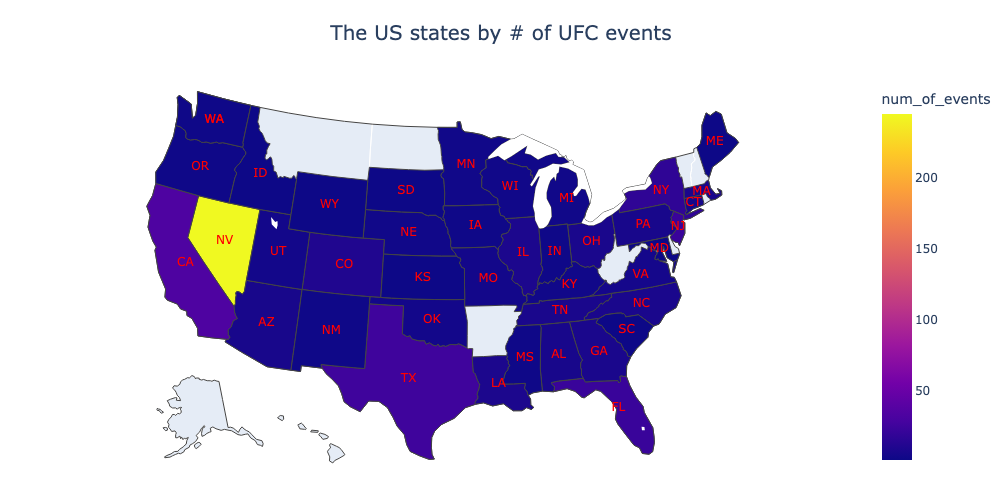

In [14]:
import plotly.express as px
import numpy as np


fig = px.choropleth(top_states,
                    locations="state_abv",
                    locationmode="USA-states",
                    color='num_of_events',
                    scope="usa",
                    title="The US states by # of UFC events",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.add_scattergeo(
    locations=top_states["state_abv"],
    locationmode="USA-states",
    text=top_states["state_abv"],
    mode="text",
    textfont=dict(
        size=12,
        color='red'
    ),
)

# Make bigger and clearer
fig.update_layout(
    title={'x': 0.5, "font_size": 20},
    height=500, width=1000,
    geo=dict(showcountries=True),
    margin=dict(l=30, r=30, t=80, b=30)
)
fig.show()

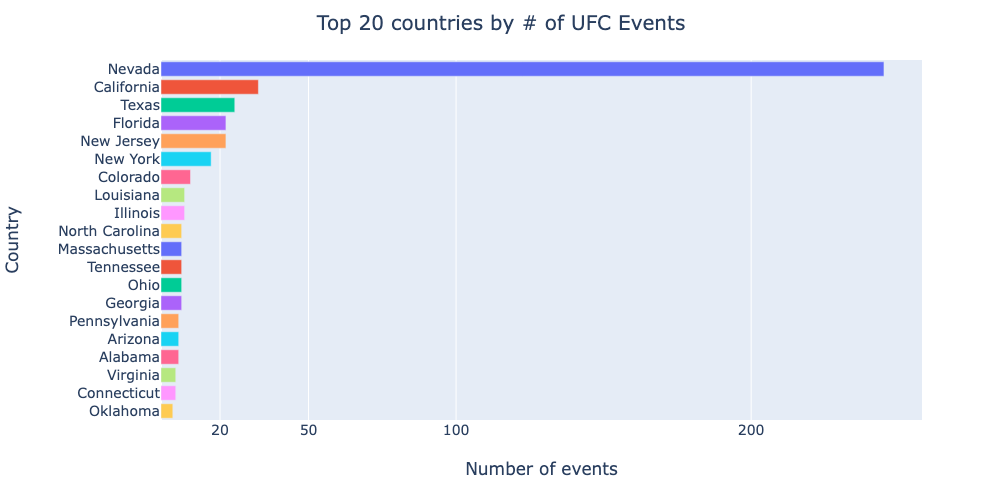

In [15]:
fig = px.bar(top_states[:20], x="num_of_events", y="state", color="state")


fig.update_layout(title={"text": "Top 20 countries by # of UFC Events", "x": 0.5, "font_size": 20},
                  font={"size": 14}, 
                  xaxis=dict(
                      tickmode='array', tickvals=[20, 50, 100, 200, 300, 400, 500],
                      title = "Number of events", title_standoff=25
                  ),
                  yaxis=dict(
                      title="Country", title_standoff=40
                  ),
                  
                  showlegend=False, height=500)

fig.show()

In [57]:
# Calculate what pct of UFC events take place in the US
nevada_pct = (top_states["num_of_events"] / sum(top_states["num_of_events"]) * 100).iloc[0]

# Prep the data
pct = pd.DataFrame({"state": ["Nevada", "Others"], "pct_of_events": [nevada_pct, 100 - nevada_pct]})
pct

,state,pct_of_events
0,Nevada,48.804781
1,Others,51.195219


Plot:

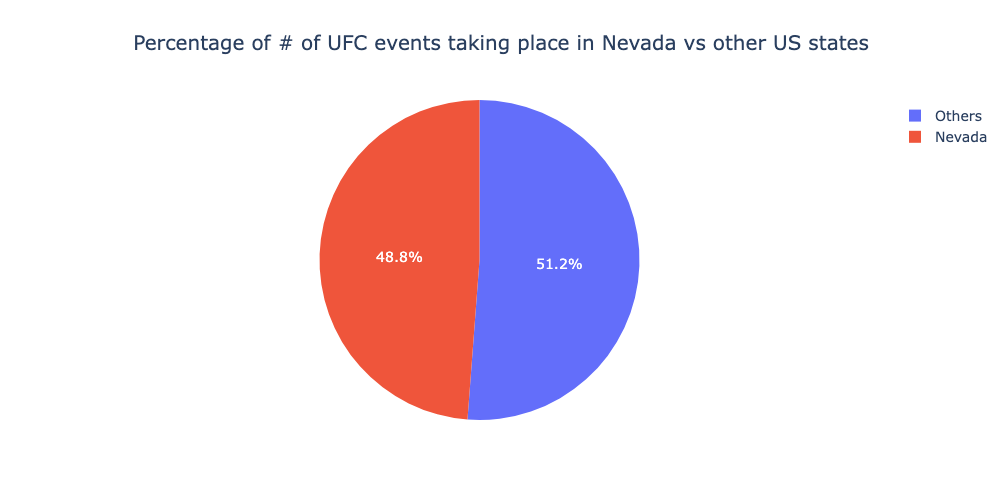

In [58]:
fig = px.pie(pct, values="pct_of_events", names="state",
             title="Percentage of # of UFC events taking place in Nevada vs other US states", height=500)

fig.update_layout(title={"x": 0.5, "font_size": 20},
                  font={"size": 14})

fig.update_traces(textfont_size=14, textfont={'color': 'white'})

fig.show()

Let's take a look at a few:
* Nevada is #1 as Las Vegas is the fight capital of the world, it is considered the home of boxing since 1960s (Muhammad Ali, Mike Tyson, Mayweather), the biggest fights are usually expected to be in Vegas. So UFC benefits from Las Vegas's established reputation as the world's top fight city. Some other reasons are that UFC is headquartered in Las Vegas, Nevada's State Athletic Commission being fighter-friendly and high tourism aspect.
* California at #2 because of the largest population in the U.S. has huge fanbase and ticket demand, also CA has been longtime MMA-friendly since it was the first state to regulate MMA (1990s) also LA events are very good for media eyeballs.
* Texas at #3 because of the low-friction regulation, drug testing and licencing is usually easier in Texas. Additionally, Texas offers stadium-sized venues like Toyota Center and passionate fanbase.
* Florida at #4 also because of low regulatory risk, and one a place for capturing Latin/Caribbean fanbase.
* New York at #6 is interesting, even though the strictest regulation, UFC literally lobbied 10+ years to legalize MMA, which finally passed in 2016. NY is prestige & media, MSG is known as "World's most famous arena", NY cards are often loaded PPVs.

## 2. What is the historical average amount of UFC fights hosted annually?

Preparing the data for plotting. Dropping duplicates, saving only the annual data, and then sorting it:

In [16]:
# Drop duplicates
events_annually = df[['event_name', 'event_date']].drop_duplicates()
# Extracting annual data
events_annually['event_year'] = pd.to_datetime(events_annually['event_date'], dayfirst=True).dt.year

# Sorting 
events_annually_counts = events_annually['event_year'].value_counts(sort=False)
# Making it look more presentable
events_annually_counts = events_annually_counts.reset_index().rename(columns={'count': 'num_of_events'})

# Taking a look
events_annually_counts.head()

,event_year,num_of_events
0,2024,36
1,2023,43
2,2022,42
3,2021,43
4,2020,41


Let's plot this:

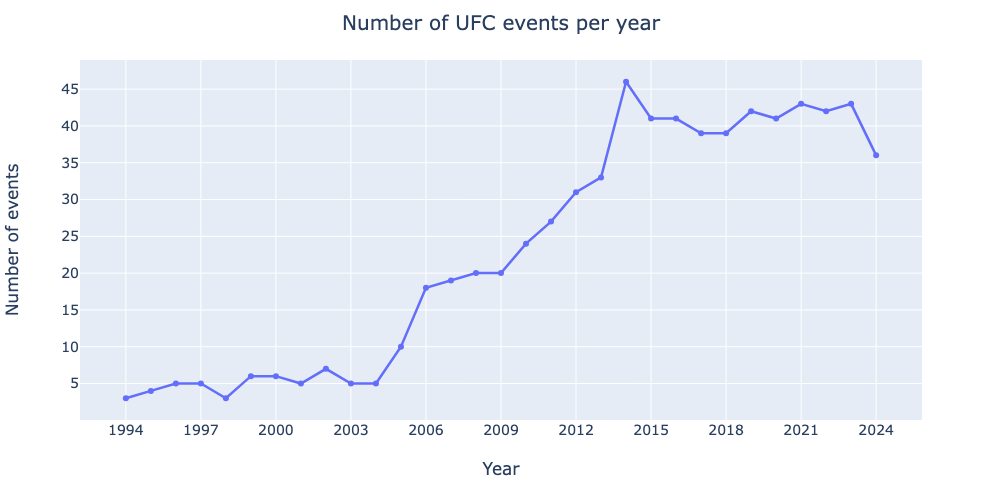

In [17]:
fig = px.line(events_annually_counts, x='event_year', y='num_of_events', markers=True)

# Cosmetics config
fig.update_layout(title={"text": "Number of UFC events per year", "x": 0.5, "font_size": 20},
                  font={"size": 14}, 
                  xaxis=dict(
                      tick0=1994, # this specifies the x axis tick to start from
                      dtick=3, # this specifies the step of x axis ticks
                      title = "Year", title_standoff=25
                  ),
                  yaxis=dict(
                      title="Number of events", title_standoff=40
                  ),
                  height=500)

# Increase the width of the line
fig.update_traces(patch={"line": {"width": 2.5}})
fig.show()

We can observe the following:
* The chart starts out with initial steady growth throughout 1995-2004, fluctuating of 4 events on average;
* Then, the 2005-2010 era, is where the UFC signed a deal with Spike TV to broadcast The Ultimate Fighter show, at the same time UFC starts being taken as a legitimate sports property, shifting perception from the "human cockfighting" to "real sport" in controlled, regulated environment, UFC starts expanding.
* In 2011-2014 UFC enters Brazil, Asia, Europe - showcased by a jump from 27 => 46 events.
* In 2015-2019 there's steady number of annual events, ~40 on average, UFC signs deal with ESPN, becomes more structured, stable, profitable.
* 2020-2021 is interesting, it's the COVID era, but UFC did well, due to having build UFC Apex (UFC's own custom facility that is adapted to hosting events, as well as a training facility) a year before in 2019 as well as Abu Dhabi's built fight island. This allows them to continue hosting events behind closed doors (no other leage could do that).
* 2021-2024 shows how fast UFC normalized their events, where Florida was the first state to allow them continue hosting events
* 2024 is still going so we're not going to draw any conclusions here just yet.

## 3. What are the top fight outcomes?

Getting the data ready:

In [18]:
# Get the counts per every victory method
top_fight_outcomes = df['method'].value_counts()

# Extracting data
outcomes = top_fight_outcomes.index
counts = top_fight_outcomes.values

# Taking a peak
top_fight_outcomes

method
Decision - Unanimous       2793
KO/TKO                     2484
Submission                 1550
Decision - Split            750
TKO - Doctor's Stoppage      94
Decision - Majority          60
DQ                           23
Name: count, dtype: int64

Plotting it:

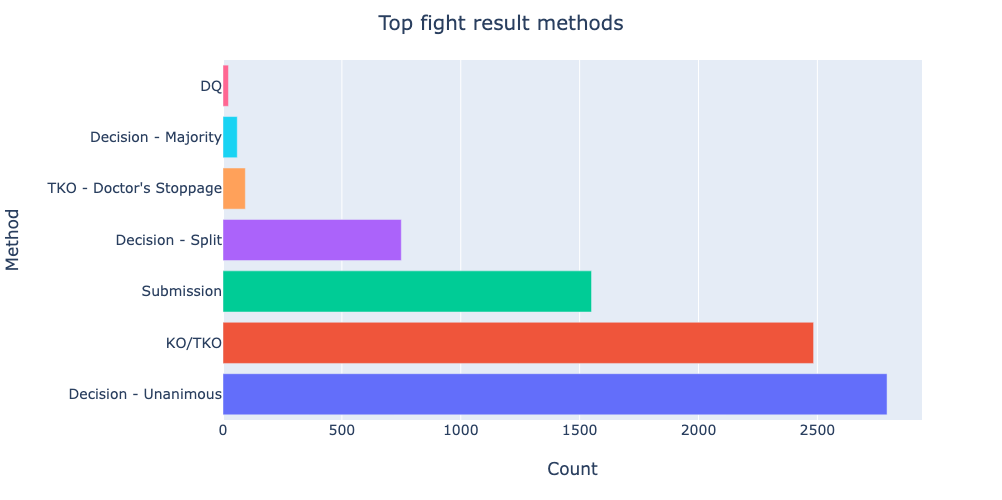

In [19]:
fig = px.bar(x=counts, y=outcomes, color=outcomes)

# Cosmetics config
fig.update_layout(title={"text": "Top fight result methods", "x": 0.5, "font_size": 20},
                  font={"size": 14}, 
                  xaxis=dict(
                      title = "Count", title_standoff=25
                  ),
                  yaxis=dict(
                      title="Method", title_standoff=40
                  ),
                  showlegend=False, height=500)
fig.show()

* The top 1 result is a win by Decision - Unanimous. The reason for that is that: 1 - it is much harder to KO/TKO or submit an opponent as it usually indicates a significant difference in expertese / level of fighters, and 2 - is probably the fact that a lot of the fighters like to "play safe", avoid taking big risks and just win by points.
* The top 2 is KO/TKO, followed by submission at top 3, which is just a grappler's way of KO/TKOing someone. KO/TKO is more common due to two reasons: 1 - the fights, as well as each round, start in stand-up (from striking position) and not from wrestling position, meaning on average, fighters spend more time striking than grappling, 2 - There is more strikers than wrestlers in the UFC roster, and potentially 3 - Fighters might, sometimes, avoid wrestling as the fans do not like it and say that it is "boring" and prefer striking instead.
* At top 4 - Decision - Split, is when only 2 judges out of 3 gave the victory to the winner. Usually happens relatively more rare, as the judges are, usually, on the same page when it comes to a winner.
* At top 5 - TKO Doctor's Stoppage - the result, when a fighter is deemed unfit by a doctor or referee to continue to fight due to an injury, even less likely, because, usually, small cuts or swellings that could naturally happen during the fight are not deemed to unfit to continue, and it is marginally much rarer that a fighter sustained a significant injury and is not knocked out or submitted.
* At top 6 - Decision - Majority, almost the same as Decision - Split, but instead of the 2 out of 3 judges giving victory to the winner and the 3rd giving victory to the loser, in Majority Decision the third judge scores the fight as draw. The majority decisions are less common because it is harder statistically, one fighter would have to be scored two 10-8 rounds and then the other fighter one 10-8 round in a 3-rd fight, which is rarer, or a round being scored 10-10 which is even less likely as judges are discouraged to do that, unless it is impossible to assign the winner of the round, even no slightest difference can be noted, or a combination of the factors above + point deductions, which happen in fewer than 2% of the fights.
* At top 7 - DQ, DQ is disqualification, it is the rarest, as the fighters are usually very careful when it comes to the rules, and disqualification effectively means loss, so they'd rather try and win even if they're losing than outright lose.

## 4. Does being in a particular corner contribute to a victory?

Data:

In [20]:
# Sorting
winners_by_corner = df['winner'].value_counts()

# Converting into pct
winners_by_corner = winners_by_corner / sum(winners_by_corner) * 100

Let's plot:

In [21]:
winners_by_corner = pd.DataFrame(winners_by_corner).reset_index()
winners_by_corner

,winner,count
0,red,65.0374
1,blue,34.9626


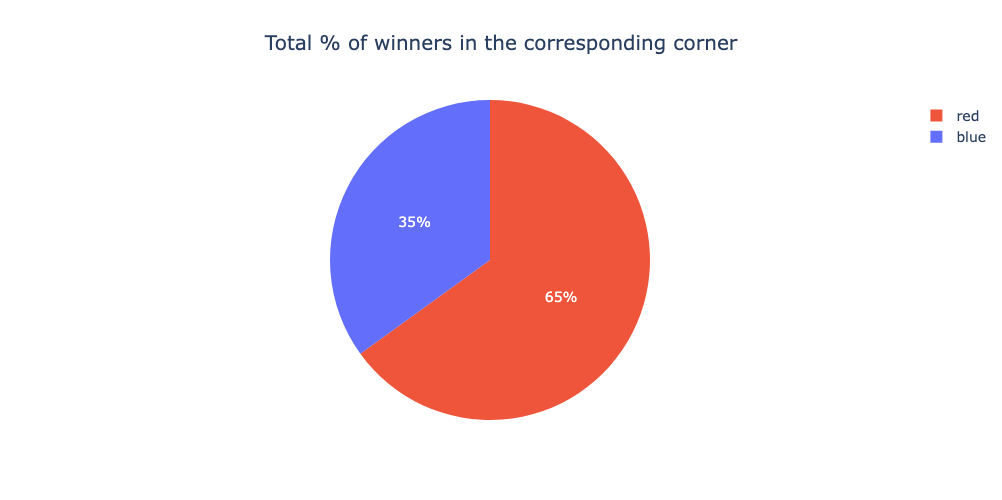

In [22]:
fig = px.pie(winners_by_corner, values='count', names='winner',
             title="Total % of winners in the corresponding corner", height=500,
            color = 'winner', color_discrete_map={'red':'EF553B','blue':'636EFA'})

fig.update_layout(title={"x": 0.5, "font_size": 20},
                  font={"size": 14}, )

fig.update_traces(textfont_size=14, textfont={'color': 'white'})

fig.show()

* The red corner is the dominant since it is given to champions, and, higher-ranked fighters.
* Where blue is assigned to lower-ranked fighters and title challengers.

## 5. Does having a specific fighting stance contribute to a victory?

### Let's examine a few features between a winner and a loser:

#### Fighting stance

Now, let's take a look at whether fighting stance matters.

All possible stances:

In [23]:
set(df.winner_stance.unique().tolist() + df.loser_stance.unique().tolist())

{'Open Stance', 'Orthodox', 'Sideways', 'Southpaw', 'Switch', nan}

Let's drop the 0's:

In [24]:
cols = [['winner_stance', 'loser_stance']]
idxs = df[(df['winner_stance'] == "0") | (df['loser_stance'] == "0")].index

stances_df = df[['winner_stance', 'loser_stance']].drop(index=idxs).dropna()

In [25]:
stances_df['winner_stance'].value_counts()

winner_stance
Orthodox       4937
Southpaw       1416
Switch          315
Open Stance      13
Sideways          2
Name: count, dtype: int64

In [26]:
stances_df['loser_stance'].value_counts()

loser_stance
Orthodox       5101
Southpaw       1287
Switch          280
Open Stance      11
Sideways          4
Name: count, dtype: int64

Let's calculate win rate for each stance:

In [27]:
# Stances total
stances_total = stances_df['winner_stance'].value_counts().add(stances_df['loser_stance'].value_counts(), fill_value=0)

# Stances win rate
stances_wr = (stances_df['winner_stance'].value_counts().div(stances_total, fill_value=0) * 100).sort_values()
stances_wr

winner_stance
Sideways       33.333333
Orthodox       49.183104
Southpaw       52.386238
Switch         52.941176
Open Stance    54.166667
Name: count, dtype: float64

Good.

Let's examine the different stance matchups:

In [28]:
stances_df.value_counts()

winner_stance  loser_stance
Orthodox       Orthodox        3814
Southpaw       Orthodox        1056
Orthodox       Southpaw         917
Southpaw       Southpaw         295
Switch         Orthodox         220
Orthodox       Switch           196
Switch         Southpaw          72
Southpaw       Switch            61
Switch         Switch            23
Open Stance    Orthodox          10
Orthodox       Open Stance        7
Southpaw       Open Stance        3
Open Stance    Southpaw           3
Orthodox       Sideways           3
Southpaw       Sideways           1
Sideways       Open Stance        1
               Orthodox           1
Name: count, dtype: int64

In [29]:
# Pick rows, where the stances of both fighters are the same
samestance_idxs = stances_df[stances_df.winner_stance == stances_df.loser_stance].index

# Drop same stance matchups
stances_df.drop(index=samestance_idxs, inplace=True)

In [30]:
matchup_cnts = stances_df.value_counts().reset_index()
matchup_cnts

,winner_stance,loser_stance,count
0,Southpaw,Orthodox,1056
1,Orthodox,Southpaw,917
2,Switch,Orthodox,220
3,Orthodox,Switch,196
4,Switch,Southpaw,72
5,Southpaw,Switch,61
6,Open Stance,Orthodox,10
7,Orthodox,Open Stance,7
8,Open Stance,Southpaw,3
9,Orthodox,Sideways,3


Normalize winner/loser_stance Southpaw:Orthodox and loser/winner_stance Orthodox:Southpaw into a single group Southpaw:Orthodox to get the total counts needed for ratio calculations:

In [31]:
stances_df['stance_pairs'] = stances_df.apply(lambda row: tuple(sorted([row['winner_stance'], row['loser_stance']])), axis=1)
stance_pairs_cnts = dict(stances_df['stance_pairs'].value_counts())
stance_pairs_cnts

{('Orthodox', 'Southpaw'): 1973,
 ('Orthodox', 'Switch'): 416,
 ('Southpaw', 'Switch'): 133,
 ('Open Stance', 'Orthodox'): 17,
 ('Open Stance', 'Southpaw'): 6,
 ('Orthodox', 'Sideways'): 4,
 ('Sideways', 'Southpaw'): 1,
 ('Open Stance', 'Sideways'): 1}

In [32]:
stances_df['stance_pairs_cnts'] = stances_df['stance_pairs'].apply(lambda val: stance_pairs_cnts[val])
stances_df.head()

,winner_stance,loser_stance,stance_pairs,stance_pairs_cnts
27,Switch,Orthodox,"(Orthodox, Switch)",416
28,Southpaw,Orthodox,"(Orthodox, Southpaw)",1973
38,Switch,Orthodox,"(Orthodox, Switch)",416
41,Southpaw,Orthodox,"(Orthodox, Southpaw)",1973
45,Orthodox,Southpaw,"(Orthodox, Southpaw)",1973


In [33]:
matchup_cnt = pd.DataFrame(stances_df[['winner_stance', 'loser_stance']].value_counts()).reset_index()
matchup_cnt

,winner_stance,loser_stance,count
0,Southpaw,Orthodox,1056
1,Orthodox,Southpaw,917
2,Switch,Orthodox,220
3,Orthodox,Switch,196
4,Switch,Southpaw,72
5,Southpaw,Switch,61
6,Open Stance,Orthodox,10
7,Orthodox,Open Stance,7
8,Open Stance,Southpaw,3
9,Orthodox,Sideways,3


In [34]:
stances_df = stances_df.merge(matchup_cnt, how='left', on=['winner_stance', 'loser_stance']).rename(columns={'count': 'matchup_cnt'})
stances_df

,winner_stance,loser_stance,stance_pairs,stance_pairs_cnts,matchup_cnt
0,Switch,Orthodox,"(Orthodox, Switch)",416,220
1,Southpaw,Orthodox,"(Orthodox, Southpaw)",1973,1056
2,Switch,Orthodox,"(Orthodox, Switch)",416,220
3,Southpaw,Orthodox,"(Orthodox, Southpaw)",1973,1056
4,Orthodox,Southpaw,"(Orthodox, Southpaw)",1973,917
...,...,...,...,...,...
2546,Orthodox,Southpaw,"(Orthodox, Southpaw)",1973,917
2547,Sideways,Open Stance,"(Open Stance, Sideways)",1,1
2548,Southpaw,Orthodox,"(Orthodox, Southpaw)",1973,1056
2549,Orthodox,Southpaw,"(Orthodox, Southpaw)",1973,917


In [35]:
stances_df.drop_duplicates(subset=['loser_stance', 'winner_stance'], inplace=True)

# Calc win rate
stances_df['stance_matchups_wr'] = (stances_df.matchup_cnt.div(stances_df.stance_pairs_cnts) * 100).round(2)

# Drop now irrelevant cols for interpretability
stances_df = stances_df.loc[:, ['winner_stance', 'loser_stance', 'stance_matchups_wr', 'matchup_cnt']]

In [36]:
stances_df

,winner_stance,loser_stance,stance_matchups_wr,matchup_cnt
0,Switch,Orthodox,52.88,220
1,Southpaw,Orthodox,53.52,1056
4,Orthodox,Southpaw,46.48,917
7,Orthodox,Switch,47.12,196
9,Southpaw,Switch,45.86,61
12,Switch,Southpaw,54.14,72
1941,Orthodox,Open Stance,41.18,7
1993,Open Stance,Southpaw,50.00,3
2114,Open Stance,Orthodox,58.82,10
2176,Southpaw,Open Stance,50.00,3


Leave only the stance matchups, where the number of recorded fights was > 5, in order to sort out the unrealistic high % pct winrates, for stances like 'Sideways' or 'Open Stance', which is very rare:

In [37]:
stances_df.sort_values(by='matchup_cnt').head(5)

,winner_stance,loser_stance,stance_matchups_wr,matchup_cnt
2540,Southpaw,Sideways,100.0,1
2542,Sideways,Orthodox,25.0,1
2547,Sideways,Open Stance,100.0,1
1993,Open Stance,Southpaw,50.0,3
2176,Southpaw,Open Stance,50.0,3


Filtering:

In [38]:
stances_df = stances_df[stances_df['matchup_cnt'] > 5]
stances_df

,winner_stance,loser_stance,stance_matchups_wr,matchup_cnt
0,Switch,Orthodox,52.88,220
1,Southpaw,Orthodox,53.52,1056
4,Orthodox,Southpaw,46.48,917
7,Orthodox,Switch,47.12,196
9,Southpaw,Switch,45.86,61
12,Switch,Southpaw,54.14,72
1941,Orthodox,Open Stance,41.18,7
2114,Open Stance,Orthodox,58.82,10


Pivoting to the expected by a heatmap format:

In [39]:
stances_df = stances_df.pivot(index='winner_stance', columns='loser_stance', values='stance_matchups_wr')
stances_df

loser_stance,Open Stance,Orthodox,Southpaw,Switch
winner_stance,,,,
Open Stance,NaN,58.82,NaN,NaN
Orthodox,41.18,NaN,46.48,47.12
Southpaw,NaN,53.52,NaN,45.86
Switch,NaN,52.88,54.14,NaN


Plotting now:

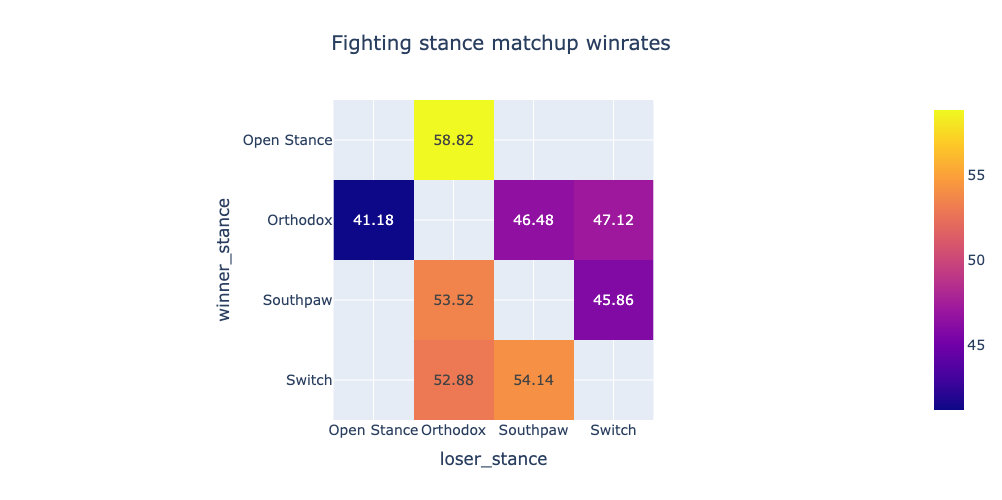

In [40]:
fig = px.imshow(stances_df, text_auto=True, height=500, title="Fighting stance matchup winrates")
fig.update_layout(title={"x": 0.5, "font_size": 20},
                  font={"size": 14}, )
fig.show()

Let's start plotting:

#### Delta features

Let's now consider other aspects of the fight, such as the total number of significant strikes landed, the number of significant strikes landed by the target: to the head, body, leg; the number of sig. str. landed by position: distance, clinch, ground; takedown accuracy, submission attempts, reversals, fight control, etc.

In [41]:
# Parse all delta features
delta_feats = [f for f in df.columns if f.startswith("delta")]
delta_feats

['delta_KD',
 'delta_sig_str_pct',
 'delta_total_str_pct',
 'delta_TD_pct',
 'delta_sub_att',
 'delta_rev',
 'delta_ctrl',
 'delta_sig_str_head_acc_pct',
 'delta_sig_str_body_acc_pct',
 'delta_sig_str_leg_acc_pct',
 'delta_sig_str_distance_acc_pct',
 'delta_sig_str_clinch_acc_pct',
 'delta_sig_str_ground_acc_pct',
 'delta_sig_str_head_tar_pct',
 'delta_sig_str_body_tar_pct',
 'delta_sig_str_leg_tar_pct',
 'delta_sig_str_distance_pos_pct',
 'delta_sig_str_clinch_pos_pct',
 'delta_sig_str_ground_pos_pct',
 'delta_height',
 'delta_reach',
 'delta_slpm_cs',
 'delta_str_acc_cs',
 'delta_sapm_cs',
 'delta_str_def_cs',
 'delta_td_avg_cs',
 'delta_td_acc_cs',
 'delta_td_def_cs',
 'delta_sub_avg_cs']

#### Dropping NaNs

In [42]:
df[delta_feats].isna().sum()

delta_KD                            21
delta_sig_str_pct                    0
delta_total_str_pct                 21
delta_TD_pct                         0
delta_sub_att                       21
delta_rev                           21
delta_ctrl                         199
delta_sig_str_head_acc_pct          21
delta_sig_str_body_acc_pct          21
delta_sig_str_leg_acc_pct           21
delta_sig_str_distance_acc_pct      21
delta_sig_str_clinch_acc_pct        21
delta_sig_str_ground_acc_pct        21
delta_sig_str_head_tar_pct          21
delta_sig_str_body_tar_pct          21
delta_sig_str_leg_tar_pct           21
delta_sig_str_distance_pos_pct      21
delta_sig_str_clinch_pos_pct        21
delta_sig_str_ground_pos_pct        21
delta_height                       941
delta_reach                       2049
delta_slpm_cs                      905
delta_str_acc_cs                   905
delta_sapm_cs                      905
delta_str_def_cs                   905
delta_td_avg_cs          

In [43]:
# Shape before
before = df.shape

df = df.dropna(subset=delta_feats)

# Before vs After
before, df.shape

((7754, 42), (5700, 42))

In [44]:
df[delta_feats].isna().sum()

delta_KD                          0
delta_sig_str_pct                 0
delta_total_str_pct               0
delta_TD_pct                      0
delta_sub_att                     0
delta_rev                         0
delta_ctrl                        0
delta_sig_str_head_acc_pct        0
delta_sig_str_body_acc_pct        0
delta_sig_str_leg_acc_pct         0
delta_sig_str_distance_acc_pct    0
delta_sig_str_clinch_acc_pct      0
delta_sig_str_ground_acc_pct      0
delta_sig_str_head_tar_pct        0
delta_sig_str_body_tar_pct        0
delta_sig_str_leg_tar_pct         0
delta_sig_str_distance_pos_pct    0
delta_sig_str_clinch_pos_pct      0
delta_sig_str_ground_pos_pct      0
delta_height                      0
delta_reach                       0
delta_slpm_cs                     0
delta_str_acc_cs                  0
delta_sapm_cs                     0
delta_str_def_cs                  0
delta_td_avg_cs                   0
delta_td_acc_cs                   0
delta_td_def_cs             

#### Plotting

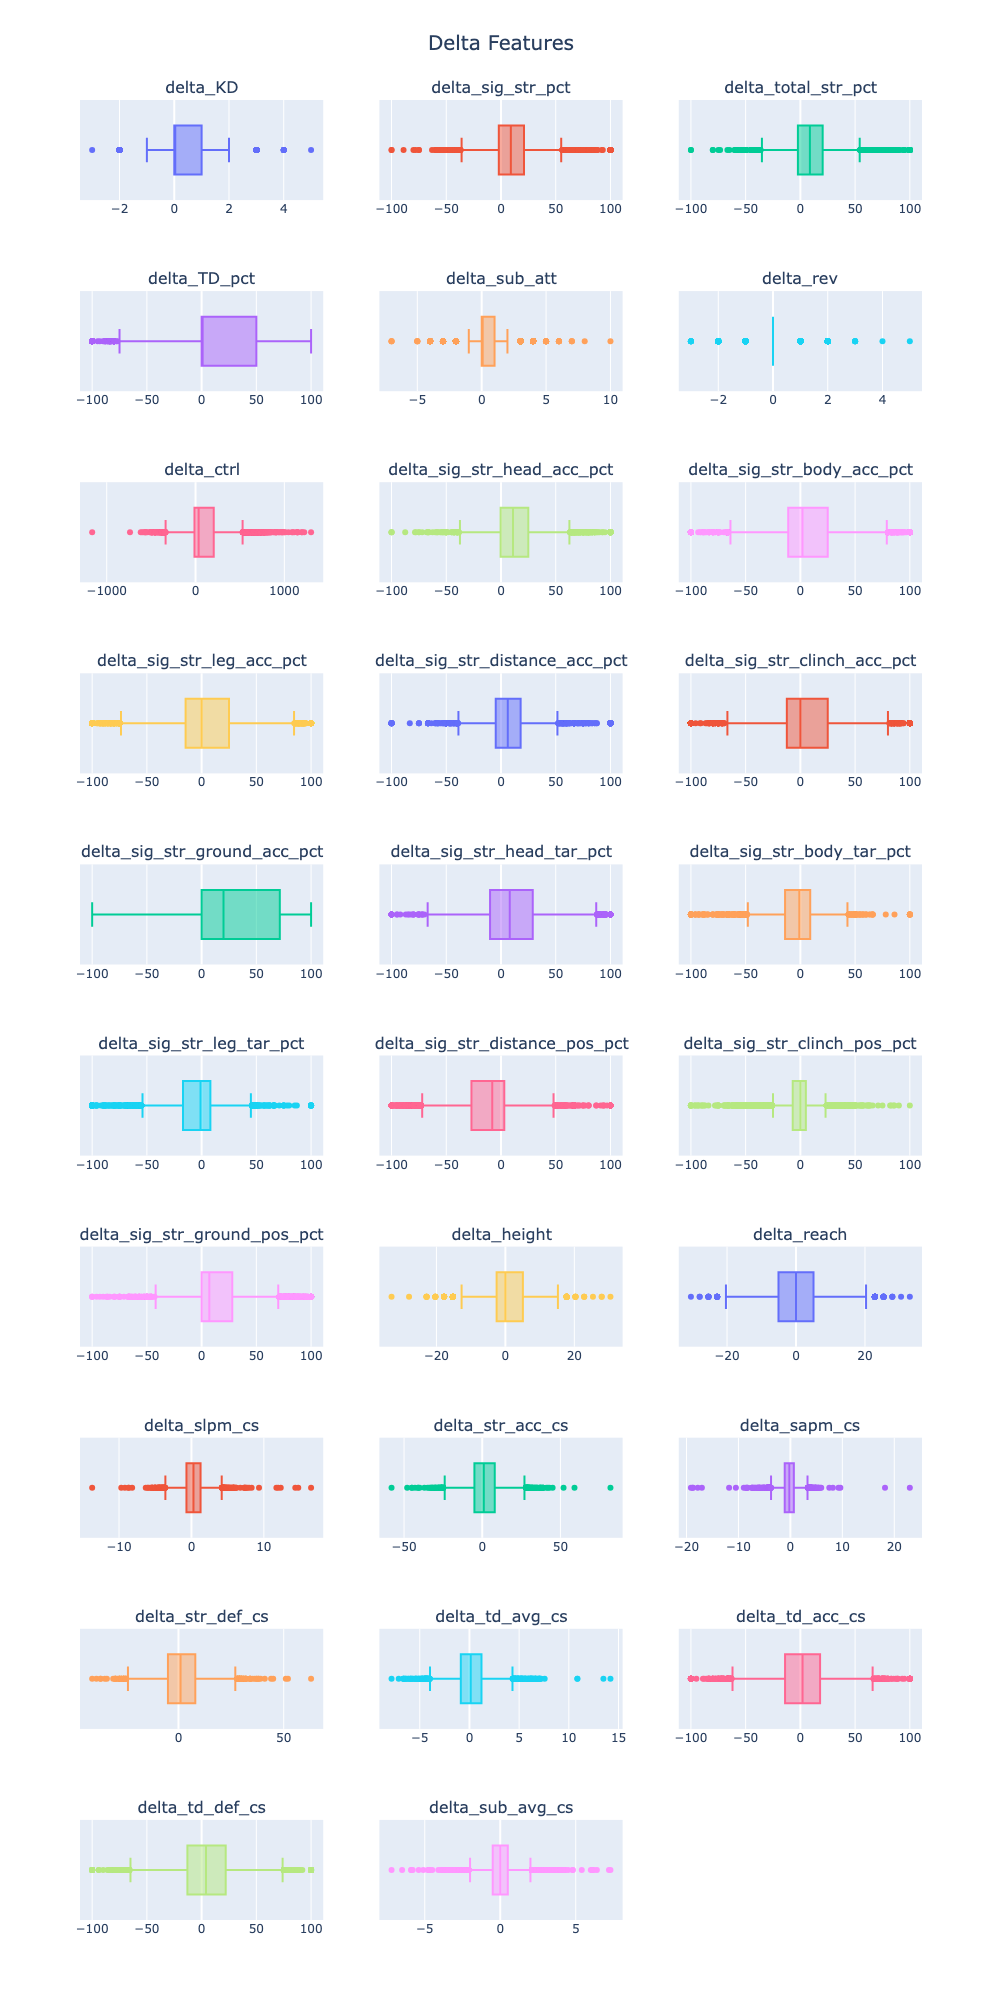

In [45]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

ROWS, COLS = 10, 3

fig = make_subplots(rows=ROWS, cols=COLS,
                   subplot_titles=delta_feats)

fig.add_traces(
    [go.Box(x=df[f]) for f in delta_feats],
    rows=[1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6,7,7,7,8,8,8,9,9,9,10,10],
    cols=[1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2]
)

fig.update_yaxes(showticklabels=False)
fig.update_layout(height=2000, width=1000, showlegend=False, title={"text": "Delta Features",
                                                                    "x": 0.5, "font_size": 20})

fig.show()

#### Cohen's D

For better interpretability, let's do the Cohen's D test on these features. It will assist us in ranking the importance of these features, and the nice property of Cohen's D is that it measures the **standardized effect**, which comes in handy in our case, because we have features that are on different scales, some of them are in percentages, some in seconds, which would be ranked as the top features due to the scale difference only.

Since we've already transformed both populations of every single feature into their delta versions, we're going to run the test as a single group against the mean of 0:

In [46]:
cohensd = (df[delta_feats].mean() - 0) / df[delta_feats].std()

d_df = pd.DataFrame(data={'d': np.round(cohensd, 2)})
d_df.sort_values(by='d', ascending=False)

,d
delta_sig_str_head_acc_pct,0.59
delta_sig_str_ground_pos_pct,0.56
delta_sig_str_ground_acc_pct,0.52
delta_sig_str_pct,0.51
delta_total_str_pct,0.50
delta_KD,0.47
delta_ctrl,0.44
delta_sig_str_head_tar_pct,0.34
delta_TD_pct,0.33
delta_sig_str_distance_acc_pct,0.32


The way to interpret these D values is as follows:

In [47]:
pd.DataFrame(data={'Cohen’s d': [0.2, 0.5, 0.8], 'Effect Size': ['Small', 'Medium', 'Large']})

,Cohen’s d,Effect Size
0,0.2,Small
1,0.5,Medium
2,0.8,Large


The same for negative values. So a D value of 0.5 would indicate that there's a medium contribution of that feature to winning, a D value of -0.5 would hint at a medium contribution to losing, etc.

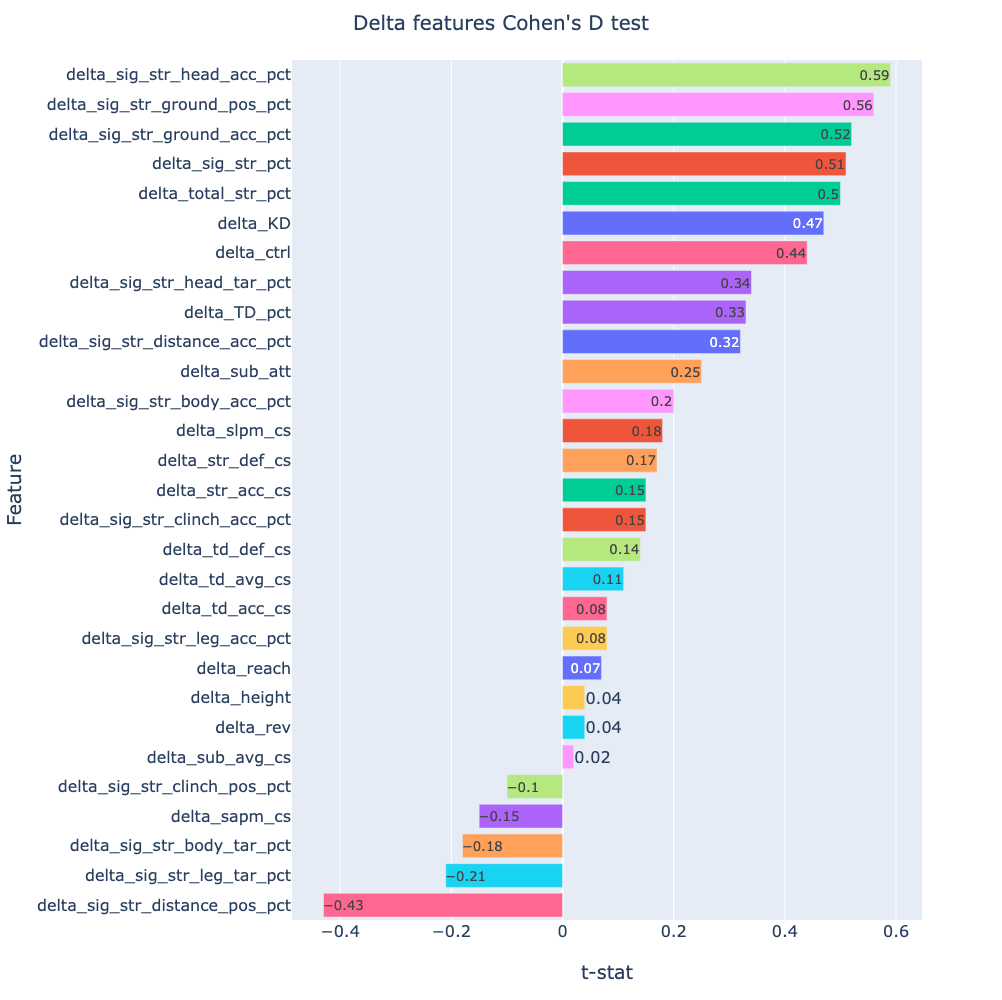

In [48]:
fig = px.bar(d_df, x='d', y=d_df.index, color=d_df.index, text_auto=True)

# Cosmetics config
fig.update_layout(title={"text": "Delta features Cohen's D test", "x": 0.5, "font_size": 20},
                  font={"size": 16}, 
                  xaxis=dict(
                      title = "t-stat", title_standoff=25,
                  ),
                  yaxis=dict(
                      title="Feature", title_standoff=40,
                      categoryorder="total ascending"
                  ),
                  showlegend=False, height=1000)
fig.show()

**Interpretation**

The most important features that contribute to winning: <br>
accuracy of significant strikes to the head, (this one seems to be very important) accuracy and position of significant strikes on the ground (vs clinch or distance), number of significant strikes landed, number of total strikes landed, number of knockdowns landed, control time, target of significant strikes to the head (vs body or leg), number of takedowns landed, accuracy of significant strikes landed from distance position (vs ground or clinch)

Not as important features, but that still do contribute to winnning: <br>
number of sumbission attempts, accuracy of significant strikes to the body (vs head or leg), career statistic of significant strikes landed per minute, cs of significant strike defence (the % of opponents strikes that did not land), cs of sig. str. accuracy, accuracy of significant strikes in clinch position (vs ground or distance), cs of takedown defence.

Features that barely contribute to winning / are in grey area: <br>
cs of avg. num. of takedowns landed per 15 min., accuracy of sig. str. to the legs, cs of takedown accuracy, fighter's reach, fighter's height, number of reversals, cs of average submissions attempted per 15 minutes.

Features that negatively contribute to winning, i.e. contribute to losing: <br>
sig. str. landed from distance position (vs ground or clinch), target of sig. str. being leg (vs head or body), target of sig. str. being body (vs head or leg), cs significant strikes absorbed per minute, sig. str. from clinch position (vs ground or distance).

#### Closer look

Now, let's take a closer look at some of the features and try and break it down why one features contribute to winning vs the other similar counterparts.

In [50]:
df[features].median().values

array([9.   , 8.705, 0.   , 0.   ])

In [ ]:
def plot_subplots(features, title):
    """Plots histograms of features in subplots and barchart of medians of these features"""
    ROWS, COLS = 1, 3
    
    hist_fig = make_subplots(rows=ROWS, cols=COLS,
                       subplot_titles=features)
    
    hist_fig.add_traces(
        [go.Histogram(x=df[f]) for f in features],
        rows=[1,1,1],
        cols=[1,2,3]
    )
    
    hist_fig.update_yaxes(showticklabels=False)
    hist_fig.update_layout(height=300, width=1000, showlegend=False,
                      title={"text": title, "x":0.5, "font_size": 20})
    hist_fig.show()

    ################ PLOT MEDIAN ################

    medians = np.round(df[features].median(), 2)
    
    med_fig = px.bar(y=medians, x=df[features].median().index,
                  color=df[features].median().index, text_auto=True)
    
    med_fig.update_yaxes(showticklabels=True, title="Value", tickfont_size=14, title_font_size=16)
    med_fig.update_xaxes(showticklabels=True, title="Feature", tickfont_size=14, title_font_size=16)
    med_fig.update_layout(height=200, width=1000, showlegend=False,
                      title={"text": "Medians", "x":0.5, "font_size": 20})
    med_fig.show()

In [ ]:
feats = ["delta_sig_str_head_acc_pct", "delta_sig_str_body_acc_pct", "delta_sig_str_leg_acc_pct"]

plot_subplots(feats,
             "Accuracy of significant strikes to the head/body/leg")

Observations:
Body and legs distributions are more symmetrical, with tons of 0's in the middle, head is slightly skewed to the right with less noise in the 0 region. Medians as follows: head at 10.9, body at 1.9, and legs at 0.

**Conclusion:** <br>
**Head > body > legs**<br>
**Winners prefer** going for and **being more accurate with their strikes on the head** > body > legs. 
The head histogram shows some skewness to the right, which points at the fact that winners slightly tend to outperform losers in that regard, also the head being stable in the 0 area compared to the other two hints at the fact how these features are calculated, they're calculated with accuracy / attempts, and when attempts are 0, the accuracy will be 0 as well thus adding a huge candle in the 0 tick on body and legs charts. 

Median is the highest for head largely because it's the cleanest distribution, whereas in the other 2 the big 0 candle "eats the median away into 0".

Accurate sig. str. to the head hint on being important in winning, following by sig. str. to the body having a smaller importance, ending with strikes to the legs showing no significant connection to winning.

But accuracy alone is not a reliable predictor of winning in fights, as a fighter may not be better on accuracy and instead, win on volume.

In [ ]:
feats = ["delta_sig_str_head_tar_pct", "delta_sig_str_body_tar_pct", "delta_sig_str_leg_tar_pct"]

plot_subplots(feats,
             "The target of significant strikes landed")

Observations:
* Pretty similar situation, body and legs being slightly more symmetrical without showing any noticeable skewness to any of the sides, whereas the head shows a positive tail.
* Same situation as before with the 0 tick, head displays being more stable in that region, while body and legs have a big candle, the type of candle you'd like to see on a meme coin you hold. But, as was said before, a big part of it is just no punches being thrown to the body/legs as a lot of the UFC fighters only go for the head. But the other reason this is true, is because the way this feature is calculated. It's calculated as the distribution of the sig. str. the fighter landed, so, if there was 40 strikes landed to the body and 20 to the head. That's 33% for the head and 66% for the body. But say, as the rounds went by, the stats are now 60 to the head, and 45 to the body. That's now 57% for the head and only 43% for the body. So, adding to one is in some way subtracting from another in this sense.
* Even though no noticeable skewness is visible on the body and legs plots, it's visible that the body and legs have slightly more outliers on the negative side, where's the contrary is true for the head.
* Medians: 8 for the head, -1 for both body and legs.


**Conclusion:** <br>
**Head > body = legs**<br>
**Winners prefer targeting their significant strikes to the head** > body = legs. 
Only the head has a positive median, positive skewness, and more outliers on the positive end, it is also more stable in the 0 region, whereas the body and legs have negative median, are symmetrical and slightly more outliers in the negative tail.

Thus, **head targeting is the key differentiator for winning**, whereas sig. str. to the body/legs seem to be less important but nonetheless, it's not like winners don't go for these targets, we can see in the num. of outliers; So they still are valuable, but yield value rather in the long run, on the other hand, head strikes are more visible, lead to cuts, thus showing significant damage, sway judges, and lead to KDs / finishes.

In [ ]:
feats = ["delta_sig_str_distance_acc_pct", "delta_sig_str_clinch_acc_pct", "delta_sig_str_ground_acc_pct"]

plot_subplots(feats,
             "Accuracy of sig. str. landed by position")

Observations:
* The distance is the most normally distributed, being the most stable in the 0 range, being slightly skewed to the right, having slitly more outliers on the positive end, and having median of 6.
* Clinch has the biggest tick 0 candle, being about symmetrical, having slightly more outliers in the positive tail and having median of 0.
* Ground has a pretty big 0 candle as well, is definitely skewed to the right, having more outliers in the positive tail and having median of 20.

**Conclusion:** <br>
**Ground > distance > clinch**<br>
Accurate sig. str. landed in the ground position seem to be the biggest differentiator, due to the highest median, clear positive skew and the outstanding number of positive outliers. Followed by strikes from distance, with still a positive median, normal distribution, and more outliers in the positive tail. Accuracy in sig. str. from clinch position do not seem to contribute much, 0 median, a bunch of noise, huge 0 tick hinting at clinching being relatively unpopular in fights, and having slightly more outliers in the positive tail.

This distribution makes sense, since, for distance, all fighters train striking from it, clinch depends on the style (Muay Thai or Wrestling), and then ground distribution makes sense, since whenever a grappler takes his opponent down, there's not much their opponent can do in the bottom position in terms of striking defense, so the difference in that position will be totally one-sided (also interesting note that if a fighter did not even throw any strikes on the ground, they will still get accuracy of 0%, thus adding to what we can observe above.)

Thus, **accurate significant strikes from the ground clearly contribute the most to winning**, whereas accurate sig. str. from distance contribute as well, but not on the same scale, and clinch does not seem to stand out in terms of as a strategy for winning.

In [ ]:
feats = ["delta_sig_str_distance_pos_pct", "delta_sig_str_clinch_pos_pct", "delta_sig_str_ground_pos_pct"]

plot_subplots(feats,
             "The position in which the sig. str. were landed")

Observations:
* The distance is negatively skewed, having about equal number of outliers on both ends, and having median of -8.
* The clinch is about normally distributed, having a huge wick at the 0 tick, not a significant number of outliers on both ends, and median of 0.
* The ground is positively skewed, having a big 0 tick as well, having slightly more outliers in the positive tail and having a median of 7.

**Conclusion:** <br>
**Ground > clinch > distance**<br>

Again, sig. str. from the ground position contribute the most to winning, thus further adding to the consensus between experts and fans that "on avg. wrestlers beat strikers".

The picture changes quite a bit for this feature, even though it's similar to the previous one. But a few things contribute to this change:
1. As was previously explained, the way this feature is calculated, as it's just a distribution across strikes from 3 positions, and how it can "eat away the other featuers"
2. 99.9% of the fighters strike from the distance, but a much lower amount of fighters strike from the other positions, e.g. ground, as there's much less wrestlers than strikers, thus adding to this picture.
3. Winners just usually like to strike from ground or clinch as it's just much safer and the environment is much more controlled (at least in the ground position).

In [ ]:
features = ["delta_sapm_cs", "delta_td_def_cs", "delta_str_def_cs"]

plot_subplots(["delta_sapm_cs", "delta_td_def_cs", "delta_str_def_cs"],
             "The distribution of defence-based features")

Observations (the scales are different, so we have to be careful here):
* Bell-shaped distribution for sapm, slightly longer tail to the right, and slightly more outliers on the left, having median of -0.2.
* Normal distribution for takedown defense carreer statistic, centered slightly more positively from 0, having sligtly more outliers in the positive tail, and having median of 4.
* Slight positive skewness for striking defense career statistic, centered about at 0, having median of 1.

**Conclusion:** <br>
**td_def > str_def > sapm_cs**<br>

This is an interesting one, because sapm is the Significant Strikes Absorbed per Minute, which means, the amount of damage the fighter receives per minute, i.e. the lower the better as opposed to the rest of the delta features. And even though the median is ~ 0, the number of outliers on the negative tail seems to be slightly bigger than on the positive tail, potentially indicating that winners might win slightly more with lower sapm_cs value. But this is not definitive, as most of the fights end in stance, and not on the ground, and the #1 fight outcome is a win by decision, thus probably making it a close fight and leading to both fighters absorbing punches.

Takedown defense is the priority here, as it has the biggest median, and usually people that wrestle have the best takedown defense, so I am not surprised here that this correlates to winning say more than striking defense, which even though has some positive skewness, but it's still centered at 0, so this doesn't seem to be a strong signal for winning in this case.

1. The homeland to the UFC - The United States of America, is the #1 country where UFC hosts its events, taking 70.8% of the total pool of countries UFC events were run in. Followed by Brazil, Canada, the UK, the UAE, Australia, Japan, Mexico, Germany, and others.

    And in terms of the US states, Nevada is #1, taking 48.8% of the total pool of the distribution of the US States, where UFC hosts it's events. Followed by California, Texas, Florida, New York, Colorado, Louisiana, Illinois, and others.

2. Initially, from 1994 - 2004 there were around 4 events on average;
   Then, from 2005 till its peak in 2014 there was rapid growth with an average annual increase of 3.6 events;
   Which followed by a small drop of 5 events in 2015, after which it was in a relative plateau with fluctuations of 2-3 events on average;
   Ends with 2024, which is not finished yet, but is on track to fit in with the latest trend.

3. Top fight outcomes are (in descending order): Decision - Unanimous, KO/TKO, Submission, Decision - split, TKO - Doctor's Stoppage, Decision - Majority, DQ.

4. 65% of all victories are coming from the fighters in the red corner, and the remaining 35% are coming from the blue corner fighters.
This happens due to how fighters are assigned a certain corner, red corner is given to the champions defending their title, and also red corners are given to the higher-ranked fighters. 

## 6. Do any specific anthropometric features (like height, reach, etc.) contribute to a victory?

In [ ]:
ROWS, COLS = 2, 2

features = ["delta_sig_str_pct", "delta_total_str_pct",
            "delta_reach", "delta_height"]

# Standardize
#df[features] = (df[features] - df[features].mean()) / df[features].std()

fig = make_subplots(rows=ROWS, cols=COLS,
                   subplot_titles=features)

fig.add_traces(
    [go.Histogram(x=df[f]) for f in features],
    rows=[1,1,2,2],
    cols=[1,2,1,2,]
)

fig.update_yaxes(showticklabels=False)
fig.update_layout(height=500, width=1000, showlegend=False, title={"text": "Obvious features", "x":0.5, "font_size": 20})

fig.show()

################ PLOT MEDIAN ################

medians = np.round(df[features].median(), 2)

med_fig = px.bar(y=medians, x=df[features].median().index,
              color=df[features].median().index, text_auto=True)

med_fig.update_yaxes(showticklabels=True, title="Value", tickfont_size=14, title_font_size=16)
med_fig.update_xaxes(showticklabels=True, title="Feature", tickfont_size=14, title_font_size=16)
med_fig.update_layout(height=200, width=1000, showlegend=False,
                  title={"text": "Medians", "x":0.5, "font_size": 20})
med_fig.show()

Observations (the scales are different, so we have to be careful here):
* distribution is roughly normal for significant strikes, slight right skew, more outliers on the positive tail, median of 9
* distribution is also roughly normal for total strikes, a bit right-skewed, more outliers on the positive tail, median of also about 9
* the distribution is very centered at 0 for reach, no noticeable skew, about the same num. of outliers, median of 0
* height is very similar to the reach, centered at 0, no skew, similar outliers, median of 0

**Conclusion:** <br>
**sig_str = total_str > reach = height**<br>

We can clearly see that the skewness, positively centered distributions, outstanding number of outliers and outstanding medians clearly show us that landing more total strikes, and landing more significant strikes contributes to winning.

Whereas anthropometric features like reach and height are neutral on average and do not add a clear advantage to a fighter, except of some matchups. For example in striking matchups, usually the consensus is, that a good tall fighter, or a good fighter with longer reach beats good shorter fighter, or good fighter with shorter reach, but it's MMA, and not only striking, and for example wrestlers, that are usually shorter by height and that have shorter reach that beat strikers offset this distribution to go back to 0.

# Answering questions

## Questions

1. What are the most popular locations where UFC hosts its events?
2. What is the historical average amount of UFC events hosted annually?
3. What are the top fight outcomes?
4. Does being in a particular corner contribute to a victory?
5. Does having a specific fighting stance contribute to a victory?
6. What are the main fight tactics contributing to a victory?
7. Do any specific anthropometric features (like height, reach, etc.) contribute to a victory?
8. Based on the findings, can we use the information to bet on a fighter?

## Answers

1. Las Vegas, Nevada, USA takes a whopping 34.6% of all the possible UFC event locations from 1994 - 2024 (not finished yet at the time of writing this notebook);
A few other top 5 locations are (in descending order):
Abu Dhabi, Abu Dhabi, United Arab Emirates;
London, England, United Kingdom;
Anaheim, California, USA;
Atlantic City, New Jersey, USA.

    We cannot define the potential reasons for this, as additional external data is needed. But likely regulation/business reasons play a role.
    
       
2. Initially, from 1994 - 2004 there were around 5 events on average;
   Then, from 2004 till its peak in 2014 there was rapid growth with an average annual increase of 3.6 events;
   Which followed by a small drop of 5 events in 2015, after which it was in a relative plateau with fluctuations of 2-3 events on average;
   Ends with 2024, which is not finished yet, but is on track to fit in with the latest trend.

   
   We can not provide the actual reasons for this, as this requires data outside the scope of this dataset. But if I were to guess why the rapid growth starting from 2004 was due to the start of adoption of UFC as a sport, and regulatory looseness in other states.


3. Top fight outcomes are (in descending order): Decision - Unanimous, KO/TKO, Submission, Decision - split, TKO - Doctor's Stoppage, Decision - Majority.
Unanimous decisions are the top fight outcome, and the reason is, probably, that it is not that easy to KO/TKO/Submit a fighter in such a high-level competition.



4. 65% of all victories are coming from the fighters in the red corner, and the remaining 35% are coming from the blue corner fighters.
This happens due to how fighters are assigned a certain corner, red corner is given to the champions defending their title, and also red corners are given to the higher-ranked fighters. 


5. Winners in general both outstrike and outwrestle losers, which is kind of obvious. But let's get deeper:


   Let's talk striking first:
   Winners score more knockdowns, significant strikes, and total strikes. But looking even further at the significant strikes by position, we saw that winners tend to land their significant strikes to the head, whereas losers tend to keep it diverse, they land their significant strikes more to the body and legs. Also when looking at the significant strikes by position, we can see that losers actually land more from the distance, a pretty equal pct of significant strikes from the clinch position, and winners land more strikes from the ground position.

   Now let's talk wrestling:
   Winners have almost twice the losers' wrestling dominance, indicating that wrestling in general contributes to a fighting victory. But again, let's get deeper into features:
   Winners land almost twice the loser's successful takedowns, and submission attempts, and even though not as much of a difference here, but still more reversals.

   Winners also have twice as much fight control as losers.

   #### Conclusion
   
   Based on this, a fighter should focus on:
   1. All aspects of wrestling (Takedowns, submission attempts, reversals);
   2. Some aspects of striking (Knockdowns, number of total strikes, significant strikes to the head, significant strikes from the ground position);
   3. Fight control time.